In [3]:
import config
import torch
# from torchvision.models.resnet import resnet50
from resnet50_dropout import resnet50
from dataset import test_loader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import time


sequence_length = config.SEQ_LENGTH
past_trajectory = config.HISTORY
history_frames = past_trajectory*2 + 3
total_maneuvers = ["none", "straight", "right", "left"]

#set random seeds
np.random.seed(config.seed)
torch.manual_seed(config.seed)


number of total sequences 90
num of sequences selected  90
Training sample instances: 72
Validation sample instances: 18
Testing sample instances: 18
Testing sample training data instances: 72


In [3]:
# Model Creation
def build_model() -> torch.nn.Module:
    # load pre-trained Conv2D model
    # '''
    model = resnet50(pretrained=True, p=config.dropout_prob)

    # change input channels number to match the rasterizer's output
    if config.DATASET == "SHIFT":
        num_in_channels = 25
    else:
        num_in_channels = 3 + (2*past_trajectory)

    model.conv1 = nn.Conv2d(
        num_in_channels,
        model.conv1.out_channels,
        kernel_size=model.conv1.kernel_size,
        stride=model.conv1.stride,
        padding=model.conv1.padding,
        bias=False,
    )
    # change output size to (X, Y) * number of future states

    if config.future_prediction > 0:
        num_targets = 2 * config.future_prediction
    else:
        num_targets = 2 * (sequence_length - past_trajectory)

    model.fc = nn.Linear(in_features=2048, out_features=num_targets)

    return model
    

class WrappedModel(nn.Module):
	def __init__(self, module):
		super(WrappedModel, self).__init__()
		self.module = module # that I actually define.
	def forward(self, x):
		return self.module(x)

In [4]:
model = build_model().to(config.DEVICE)
model = WrappedModel(model) #the model was trained on gpu with dataparallel,, need to add this to run on cpu.

# # load the model checkpoint
print('Loading checkpoint')
checkpoint = torch.load(config.model_path, map_location=config.DEVICE)

model_epoch = checkpoint['epoch']
# load model weights state_dict
model.load_state_dict(checkpoint['model_state_dict'])#, strict=False) # Error(s) in loading state_dict for ResNet: -> added strict-False
print('Loaded checkpoint at epoch', model_epoch)

Loading checkpoint
Loaded checkpoint at epoch 261


In [5]:
def dot(vA, vB):
    return vA[0]*vB[0]+vA[1]*vB[1]

def ang(lineA, lineB):
    # Get nicer vector form
    vA = [(lineA[1][0]-lineA[0][0]), (lineA[1][1]-lineA[0][1])]
    vB = [(lineB[1][0]-lineB[0][0]), (lineB[1][1]-lineB[0][1])]
    # Get dot prod
    dot_prod = dot(vA, vB)
    # Get magnitudes
    magA = dot(vA, vA)**0.5
    magB = dot(vB, vB)**0.5
    # Get cosine value
    cos_ = dot_prod/magA/magB
    # Get angle in radians and then convert to degrees

    # print(cos_, magA, magB)

    if -1<=cos_<=1: 
        angle = math.acos(cos_) #dot_prod/magB/magA)
        # angle = math.acos(dot_prod/magB/magA) #why if gives error, when cos_ = -1, seq=9957612?
    else:
        return 0, 0
    # # Basically doing angle <- angle mod 360
    ang_deg = math.degrees(angle)%360

    angle_tan = math.atan2(vB[1], vB[0]) - math.atan2(vA[1], vA[0])

    # if ang_deg-180>=0:
    #     # As in if statement
    #     return 360 - ang_deg
    # else: 
    #     return ang_deg

    return ang_deg, angle_tan

def cal_maneuver(angle_btw_lines, angle_btw_lines_tan):

    if angle_btw_lines < 5: #almost straight
        turn = 1 #straight
    elif angle_btw_lines_tan > 0 and angle_btw_lines > 5: #Right Turn
        turn = 2 #right
    elif angle_btw_lines_tan < 0 and angle_btw_lines > 5: #Left Turn
        turn = 3 #left

    return turn

def set_training_mode_for_dropout(net, training=True):
    """Set Dropout mode to train or eval."""

    for m in net.modules():
#        print(m.__class__.__name__)
        if m.__class__.__name__.startswith('Dropout'):
            if training==True:
                m.train()
            else:
                m.eval()
    return net        


In [6]:
def trajectories_plot(image, outputs, targets, j, image_agent_all, centroid_, ade, fde, history_traj, maneuver_label, maneuver_pred, output_list, outputs_var_mean, final_index, noise, plot_figures):
    """
    This function plots the regressed (predicted) keypoints and the actual 
    keypoints for each test image in the batch.
    """

    # fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig1, (ax3, ax4) = plt.subplots(1, 2)

    fig.suptitle("Seq {}".format(j))
    fig1.suptitle("Seq {}".format(j))

    img_map = np.copy(image[0, history_frames-3:history_frames, :, :])
    img_map = np.transpose(img_map, (1, 2, 0))
    img_map1 = np.copy(img_map)

    img_agent = np.copy(image[0, 0, :, :])
    img_agent = img_agent > 0.2
    img_map[img_agent] = [0.0, 0.0, 1.0] #(RGB) #blue for agents

    image_agent_all = image_agent_all > 40
    img_map1[image_agent_all] = [0.0, 0.0, 1.0] #(RGB) #blue for agents

    img_ego = np.copy(image[0, past_trajectory, :, :])
    img_ego = img_ego > 0.2
    img_map[img_ego] = [0.0, 1.0, 0.0] #(RGB) #green for ego
    img_map1[img_ego] = [0.0, 1.0, 0.0] #(RGB) #green for ego

    if config.NEIGHBOUR_RADIUS > 0:
        circle2 = plt.Circle((int(centroid_[0]), int(centroid_[1])), int(config.NEIGHBOUR_RADIUS), color='b', fill=False)
        ax2.add_patch(circle2)

    ax1.imshow(img_map)
    ax2.imshow(img_map1)
    
    # outputs = outputs.reshape(-1,2)
    # targets = targets.reshape(-1,2)
    # history_traj = history_traj.reshape(-1,2)

    ax3.set(xlim=(0, config.IMAGE_SIZE), ylim=(config.IMAGE_SIZE, 0))
    ax4.set(xlim=(0, config.IMAGE_SIZE), ylim=(config.IMAGE_SIZE, 0))

    # ax5.set(xlim=(0, config.IMAGE_SIZE), ylim=(config.IMAGE_SIZE, 0))
    # ax6.set(xlim=(0, config.IMAGE_SIZE), ylim=(config.IMAGE_SIZE, 0))

    t_= "ADE = " + str(round(ade,3)) + "\nFDE = " + str(round(fde,3)) + "\nManeuver_gt = " + total_maneuvers[maneuver_label] + "\nManeuver_pred = " + total_maneuvers[maneuver_pred] + "\nVariance = " + str(np.mean(outputs_var_mean)) 
    ax3.text(10,10,t_)

    ax1.plot(targets[:,0], targets[:,1], color='green', marker='o', linewidth=0.1, markersize=1, label='Ground-Truth')
    ax1.plot(outputs[:,0], outputs[:,1], color='red', marker='x', linewidth=0.1, markersize=1, label='Predictions')
    ax1.plot(history_traj[:,0], history_traj[:,1], color='cyan', marker='+', linewidth=0.1, markersize=1, label='history')

    ax2.plot(targets[:,0], targets[:,1], color='green', marker='o', linewidth=0.1, markersize=1, label='Ground-Truth')
    ax2.plot(outputs[:,0], outputs[:,1], color='red', marker='x', linewidth=0.1, markersize=1, label='Predictions')
    ax2.plot(history_traj[:,0], history_traj[:,1], color='cyan', marker='+', linewidth=0.1, markersize=1, label='history')

    ax3.plot(targets[:,0], targets[:,1], color='green', marker='o', markersize=0.3, linewidth=0.3, label='Ground-Truth')
    # ax3.plot(outputs[:,0], outputs[:,1], color='red', marker='x', markersize=1, label='Predictions')
    ax3.errorbar(outputs[:,0], outputs[:,1], outputs_var_mean, color='red', linestyle='None', marker='+', markersize=0.4, linewidth=0.4, label='Predictions') #capsize=0.2
    ax3.plot(history_traj[:,0], history_traj[:,1], color='cyan', marker='+', markersize=0.3, label='history')

    if final_index != -1:
        closest_output = output_list[final_index]
        closest_output = closest_output.reshape(-1,2)
        ax3.plot(closest_output[:,0], closest_output[:,1], color='b', marker='+', markersize=0.3, linewidth=0.5, label='Predictions')

    ax4.plot(targets[:,0], targets[:,1], color='green', marker='o', markersize=0.1, linewidth=0.5, label='Ground-Truth')
    ax4.plot(outputs[:,0], outputs[:,1], color='red', linestyle='None', marker='x', markersize=0.3, linewidth=0.5, label='Predictions') #capsize=0.2
    ax4.plot(history_traj[:,0], history_traj[:,1], color='cyan', marker='x', markersize=0.3, label='history')

    # ax5.plot(targets[:,0], targets[:,1], color='green', marker='o', markersize=0.3, linewidth=0.3, label='Ground-Truth')
    # # ax3.plot(outputs[:,0], outputs[:,1], color='red', marker='x', markersize=1, label='Predictions')
    # ax5.errorbar(outputs[:,0], outputs[:,1], outputs_var_mean, color='red', linestyle='None', marker='+', markersize=0.4, linewidth=0.4, label='Predictions') #capsize=0.2
    # ax5.plot(history_traj[:,0], history_traj[:,1], color='cyan', marker='+', markersize=0.3, label='history')

    # if final_index != -1:
    #     closest_output = output_list[final_index]
    #     closest_output = closest_output.reshape(-1,2)
    #     ax5.plot(closest_output[:,0], closest_output[:,1], color='b', marker='+', markersize=0.3, linewidth=0.5, label='Predictions')

    # ax6.plot(targets[:,0], targets[:,1], color='green', marker='o', markersize=0.1, linewidth=0.5, label='Ground-Truth')
    # ax6.plot(outputs[:,0], outputs[:,1], color='red', linestyle='None', marker='x', markersize=0.3, linewidth=0.5, label='Predictions') #capsize=0.2
    # ax6.plot(history_traj[:,0], history_traj[:,1], color='cyan', marker='x', markersize=0.3, label='history')

    for multiple_output in output_list:
        multiple_output = multiple_output.reshape(-1,2)
        c = np.random.rand(3,)
        ax1.plot(multiple_output[:,0], multiple_output[:,1], color=c, marker='x', markersize=0.2, linewidth=1, label='Predictions')
        ax4.plot(multiple_output[:,0], multiple_output[:,1], color=c, marker='x', markersize=0.2, linewidth=1, label='Predictions')
        # ax6.plot(multiple_output[:,0], multiple_output[:,1], color=c, marker='x', markersize=0.2, linewidth=1, label='Predictions')


    # for i in range(outputs.shape[0]):
    #     ax3.annotate(str(i), # this is the text
    #                 (outputs[i][0],outputs[i][1]), # this is the point to label
    #                 textcoords="offset points", # how to position the text
    #                 xytext=(0,10), # distance from text to points (x,y)
    #                 ha='center') # horizontal alignment can be left, right or center

    #     ax3.annotate(str(i), # this is the text
    #                 (targets[i][0],targets[i][1]), # this is the point to label
    #                 textcoords="offset points", # how to position the text
    #                 xytext=(0,10), # distance from text to points (x,y)
    #                 ha='center') # horizontal alignment can be left, right or center


    if noise:
        fig.savefig(f"{config.plots}/seq_" + str(j) + "_noise.png")
        fig1.savefig(f"{config.plots}/seq_" + str(j) + "_1_noise.png")
    else:
        fig.savefig(f"{config.plots}/seq_" + str(j) + ".png")
        fig1.savefig(f"{config.plots}/seq_" + str(j) + "_1.png")

    if plot_figures:
        plt.show()

    # plt.close()
    plt.close('all')


In [7]:
def calculate_ade(outputs, targets):

    displacement = np.linalg.norm(outputs - targets, axis=1) 
    ade = np.mean(displacement)   
    return ade

def calculate_fde(outputs, targets):

    fde = np.linalg.norm(outputs[outputs.shape[0]-1] - targets[outputs.shape[0]-1])
    return fde

In [8]:

def evaluate(model, dataloader, ade_list, fde_list, maneuver_gt, maneuver_outputs, variance_list, f, counter_1, noise, plot_figures):

    test_time_list = []

    with torch.no_grad():

        for i, data in enumerate(dataloader):

            # data = data.to(memory_format=torch.channels_last)

            if config.DATASET == "SHIFT":
                image, keypoints, availability = data['image'].to(config.DEVICE), torch.squeeze(data['keypoints'].to(config.DEVICE)), torch.squeeze(data['availability'].to(config.DEVICE))
            else:
                image, keypoints, availability, seq_id, image_agent, centroid_current, history_traj, history_traj_availability, maneuver_label = data['image'].to(config.DEVICE), torch.squeeze(data['keypoints'].to(config.DEVICE)), torch.squeeze(data['availability'].to(config.DEVICE)), torch.squeeze(data['seq_id'].to(config.DEVICE)), torch.squeeze(data['current_agent_i'].to(config.DEVICE)), torch.squeeze(data['centroid_current'].to(config.DEVICE)), torch.squeeze(data['history_traj'].to(config.DEVICE)), torch.squeeze(data['history_traj_availability'].to(config.DEVICE)), torch.squeeze(data['maneuver_label'].to(config.DEVICE))

            # flatten the keypoints
            keypoints = keypoints.view(keypoints.size(0), -1)
            keypoints = keypoints.detach().cpu().numpy()
            keypoints = ((keypoints + 1)/2)*int(config.IMAGE_SIZE)

            availability = availability.view(availability.size(0), -1)
            availability = availability.detach().cpu().numpy()

            if config.DATASET != "SHIFT":
                history_traj = history_traj.view(history_traj.size(0), -1)
                history_traj_availability = history_traj_availability.view(history_traj_availability.size(0), -1)
                image_agent = image_agent.detach().cpu().numpy()
                centroid_current = centroid_current.detach().cpu().numpy()
                history_traj = history_traj.detach().cpu().numpy()
                history_traj_availability = history_traj_availability.detach().cpu().numpy()
                maneuver_label = maneuver_label.detach().cpu().numpy()

            outputs_list = []
            ade_final = 1000
            fde_final = 1000

            for mc_run in range(config.num_monte_carlo):
                model.eval()
                model = set_training_mode_for_dropout(model, True)

                # outputs, _ = model.forward(image)
                t1 = time.time()
                outputs, _ = model(image) #outputs=model(image).reshape(keypoints.shape)-->since we flattened the keypoints, no need for reshaping
                test_time = time.time() - t1

                outputs = outputs.view(keypoints.shape[0], -1)
                outputs = outputs.detach().cpu().numpy()
                outputs = ((outputs + 1)/2)*int(config.IMAGE_SIZE)
                outputs = outputs[np.where(availability == 1)]
                keypoints1 = keypoints[np.where(availability == 1)]
                outputs_list.append(outputs)
                ade_value = calculate_ade(outputs.reshape(-1,2), keypoints1.reshape(-1,2)) * config.IMAGE_FACTOR
                fde_value = calculate_fde(outputs.reshape(-1,2), keypoints1.reshape(-1,2)) * config.IMAGE_FACTOR

                if ade_value < ade_final:
                    ade_final = ade_value
                    ade_index = mc_run

                if fde_value < fde_final:
                    fde_final = fde_value
                    fde_index = mc_run

                model = set_training_mode_for_dropout(model, False)

            test_time_list.append(test_time)
    
            image = image.detach().cpu().numpy()

            keypoints = keypoints[np.where(availability == 1)]
            keypoints = keypoints.reshape(-1,2)

            if config.DATASET != "SHIFT":
                history_traj = history_traj[np.where(history_traj_availability == 1)]
                history_traj = history_traj.reshape(-1,2)

            outputs_mean = np.mean(np.asarray(outputs_list), axis=0)
            outputs_var = np.std(np.asarray(outputs_list), axis=0)

            # outputs_mean = np.asarray(outputs_list[0])
            outputs_mean = outputs_mean.reshape(-1,2)
            outputs_var = outputs_var.reshape(-1,2)
            outputs_var_mean = np.mean(outputs_var, axis=1)
            total_uncertainty = np.mean(outputs_var_mean)
            
            ade = calculate_ade(outputs_mean, keypoints) * config.IMAGE_FACTOR
            fde = calculate_fde(outputs_mean, keypoints) * config.IMAGE_FACTOR

            if ade < ade_final:
                ade_final = ade
                ade_index = -1

            if fde < fde_final:
                fde_final = fde
                fde_index = -1

            if ade_index == fde_index:
                final_index = ade_index
            else:
                final_index = ade_index

            ade_list.append(ade)
            fde_list.append(fde)
            variance_list.append(total_uncertainty)

            if config.MANEUVER_PRESENT:
                line_history = [history_traj[past_trajectory-1], history_traj[0]]
                line_future = [outputs_mean[0], outputs_mean[-1]]
                angle_btw_lines, angle_btw_lines_tan = ang(line_history, line_future)
                maneuver_pred = cal_maneuver(angle_btw_lines, angle_btw_lines_tan)
                maneuver_gt.append(maneuver_label)
                maneuver_outputs.append(maneuver_pred)
            else:
                maneuver_label = 0
                maneuver_pred = 0

            if config.DATASET == "SHIFT":
                print("seq_id, ADE, FDE, maneuver_gt, maneuver_pred, outputs_var_mean = ", counter_1, ade, fde, maneuver_label, maneuver_pred, total_uncertainty)
                f.write(str(counter_1)+","+str(ade)+","+str(fde)+","+str(maneuver_label)+","+str(maneuver_pred)+","+str(total_uncertainty)+"\n")        
            else:
                print("seq_id, ADE, FDE, maneuver_gt, maneuver_pred, outputs_var_mean = ", seq_id.item(), ade, fde, maneuver_label, maneuver_pred, total_uncertainty)
                f.write(str(seq_id.item())+","+str(ade)+","+str(fde)+","+str(maneuver_label)+","+str(maneuver_pred)+","+str(total_uncertainty)+","+str(noise)+"\n")

            if config.DATASET == "SHIFT":
                trajectories_plot_shift(image, outputs_mean, keypoints, counter_1, ade, fde, outputs_list, outputs_var_mean, final_index)
                counter_1 = counter_1 + 1
            else:
                trajectories_plot(image, outputs_mean, keypoints, seq_id.item(), image_agent, centroid_current, ade, fde, history_traj, maneuver_label, maneuver_pred, outputs_list, outputs_var_mean, final_index, noise, plot_figures)

        return ade_list, fde_list, maneuver_gt, maneuver_outputs, variance_list, f, test_time_list


seq_id, ADE, FDE, maneuver_gt, maneuver_pred, outputs_var_mean =  6157527 0.5545194149017334 1.7831809520721436 1 1 0.0


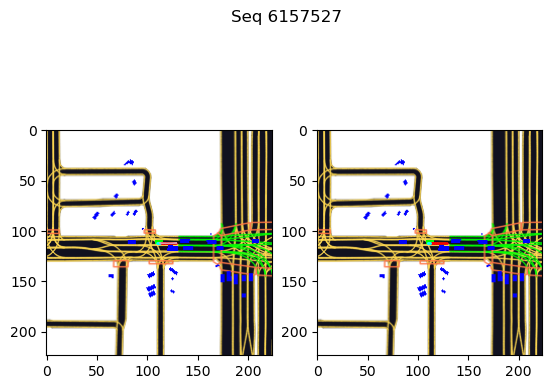

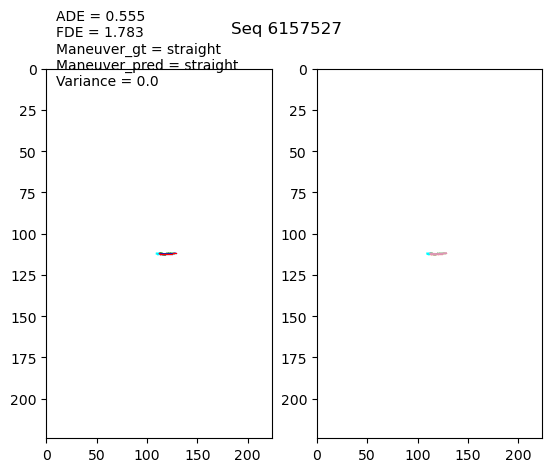

seq_id, ADE, FDE, maneuver_gt, maneuver_pred, outputs_var_mean =  6723974 1.7669564485549927 3.1152279376983643 3 1 0.0


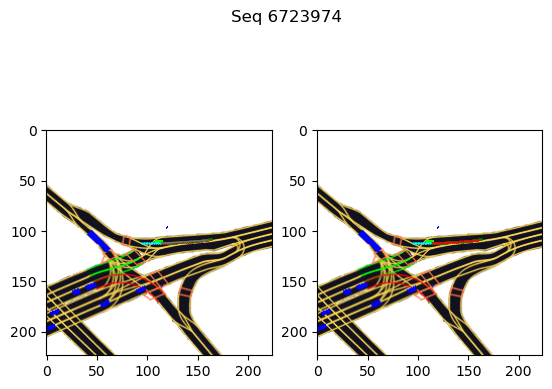

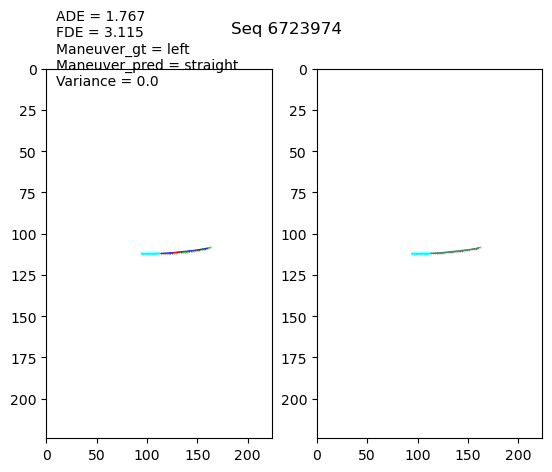

seq_id, ADE, FDE, maneuver_gt, maneuver_pred, outputs_var_mean =  7732451 3.0126476287841797 6.62000846862793 1 1 0.0


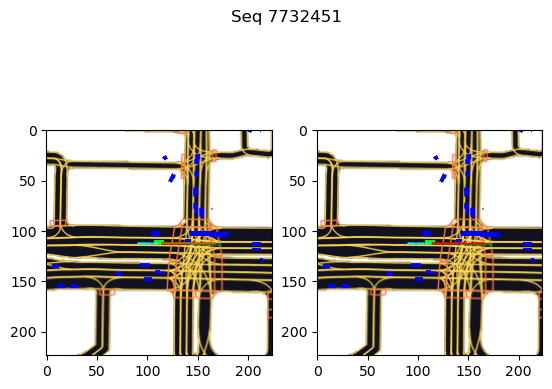

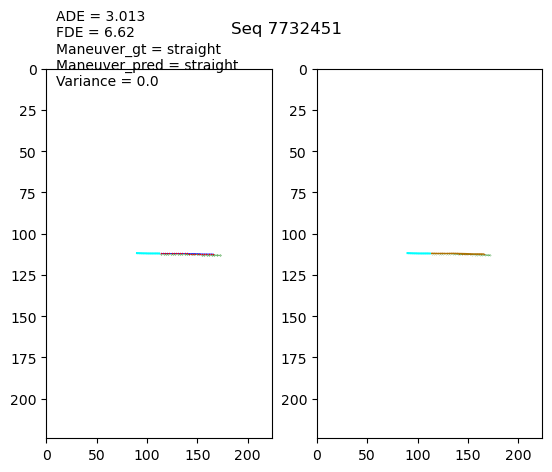

seq_id, ADE, FDE, maneuver_gt, maneuver_pred, outputs_var_mean =  22374513 1.4241371154785156 1.8233898878097534 2 2 0.0


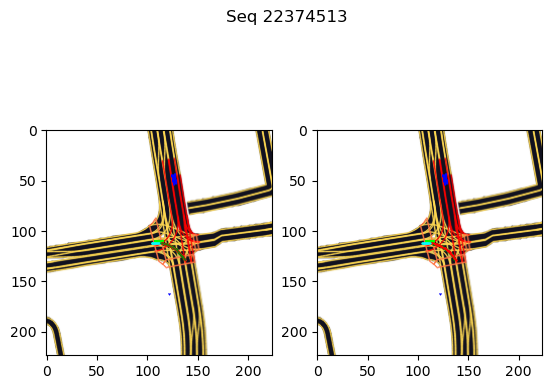

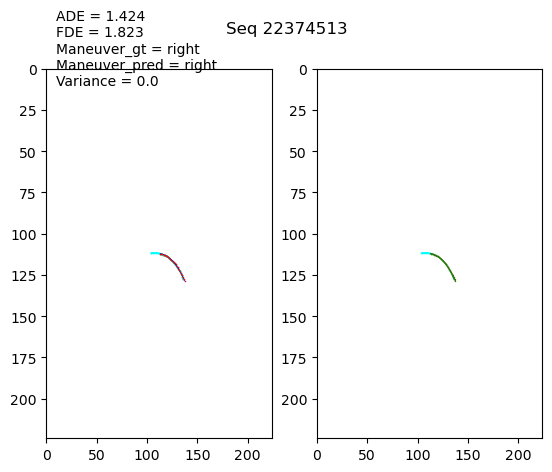

seq_id, ADE, FDE, maneuver_gt, maneuver_pred, outputs_var_mean =  276634 2.6825203895568848 6.429903984069824 1 1 0.0


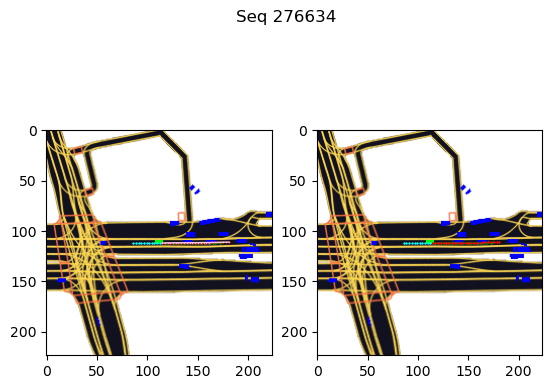

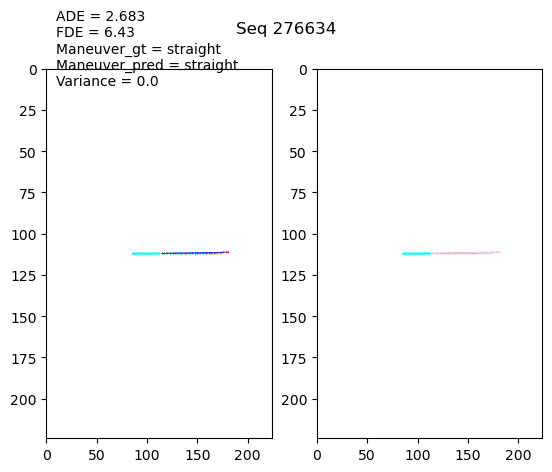

seq_id, ADE, FDE, maneuver_gt, maneuver_pred, outputs_var_mean =  16086779 1.5751255750656128 4.712669849395752 2 2 0.0


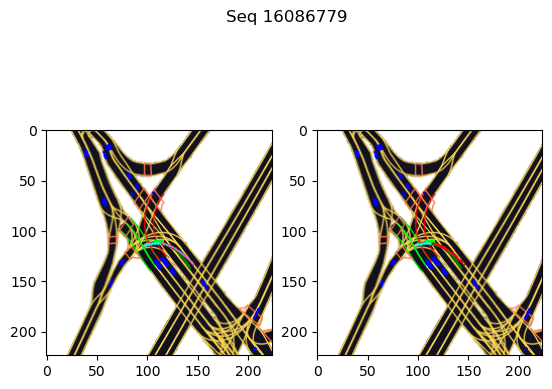

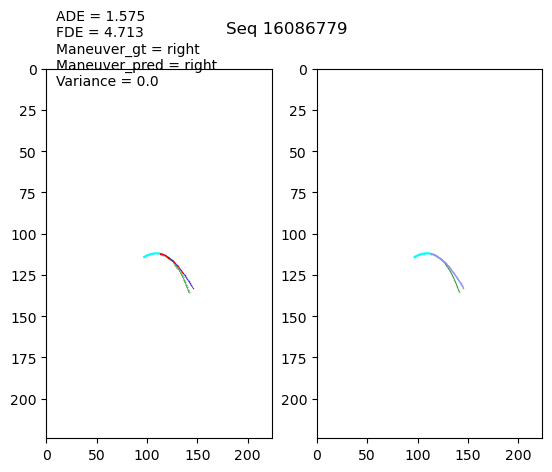

seq_id, ADE, FDE, maneuver_gt, maneuver_pred, outputs_var_mean =  22108132 1.5134698152542114 3.421142578125 1 1 0.0


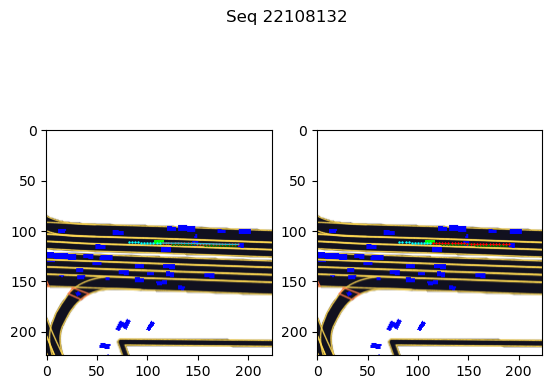

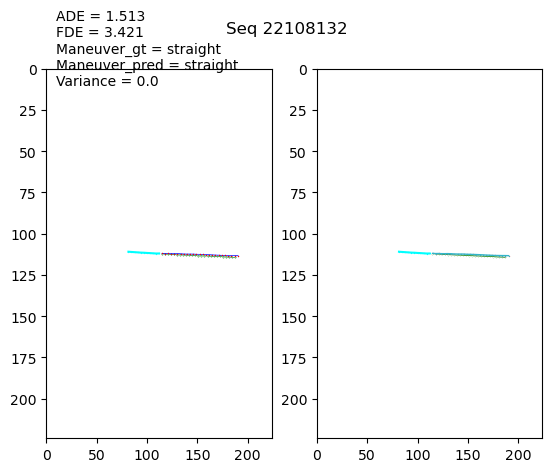

seq_id, ADE, FDE, maneuver_gt, maneuver_pred, outputs_var_mean =  8580403 1.1494724750518799 2.416503667831421 2 2 0.0


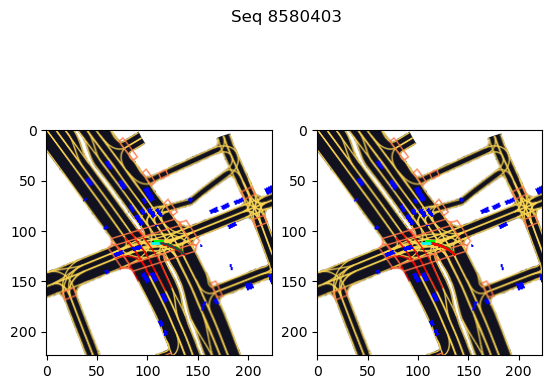

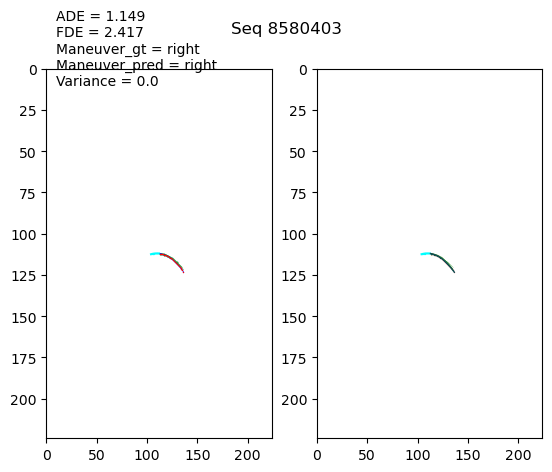

seq_id, ADE, FDE, maneuver_gt, maneuver_pred, outputs_var_mean =  1490474 4.11614465713501 9.210188865661621 1 1 0.0


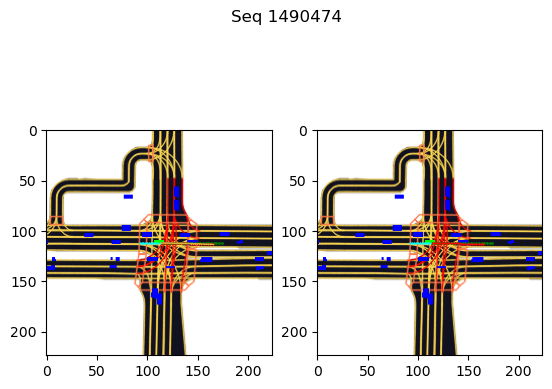

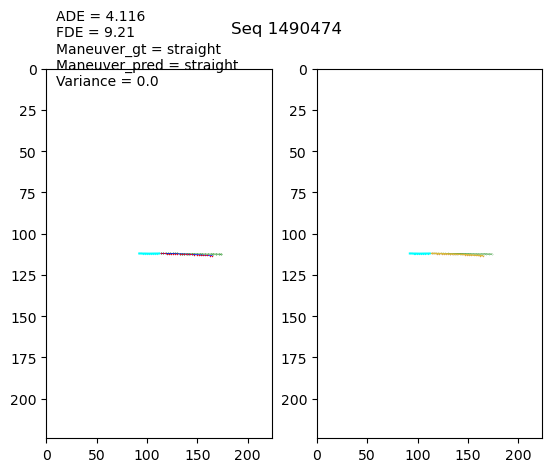

seq_id, ADE, FDE, maneuver_gt, maneuver_pred, outputs_var_mean =  6666201 1.3090039491653442 3.5286502838134766 2 2 0.0


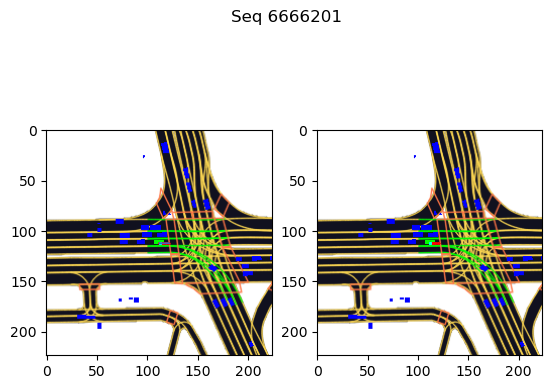

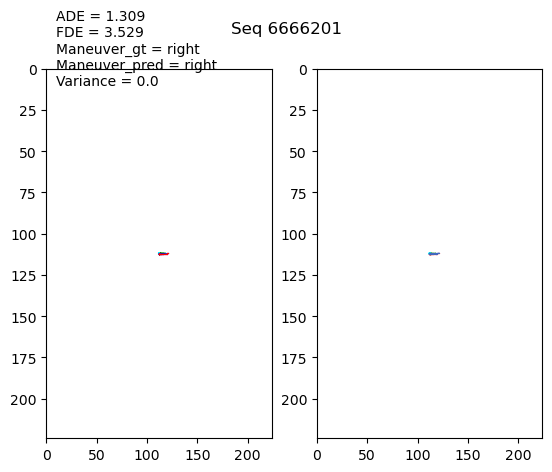

seq_id, ADE, FDE, maneuver_gt, maneuver_pred, outputs_var_mean =  7067796 1.7850826978683472 3.5639045238494873 2 1 0.0


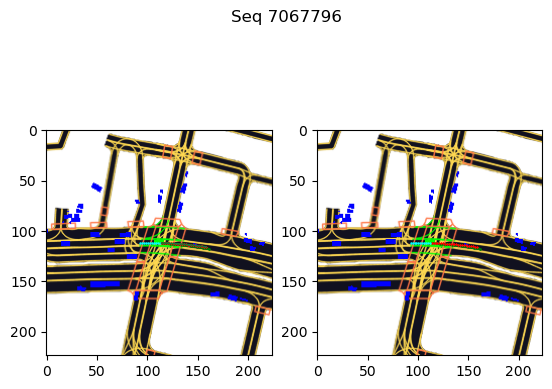

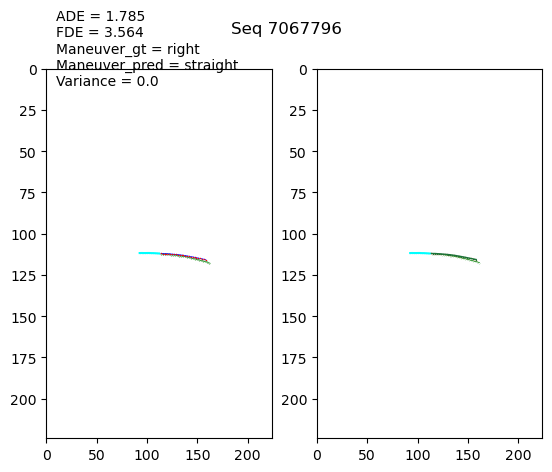

seq_id, ADE, FDE, maneuver_gt, maneuver_pred, outputs_var_mean =  7965952 1.8926520347595215 5.182058811187744 2 2 0.0


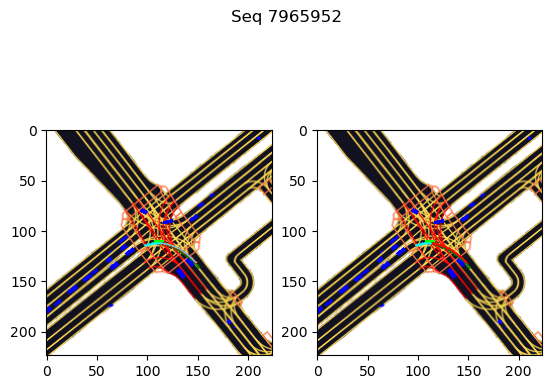

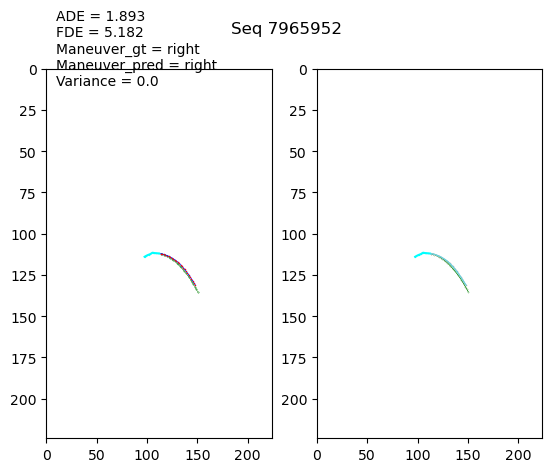

seq_id, ADE, FDE, maneuver_gt, maneuver_pred, outputs_var_mean =  19675067 1.4629278182983398 1.4171198606491089 3 3 0.0


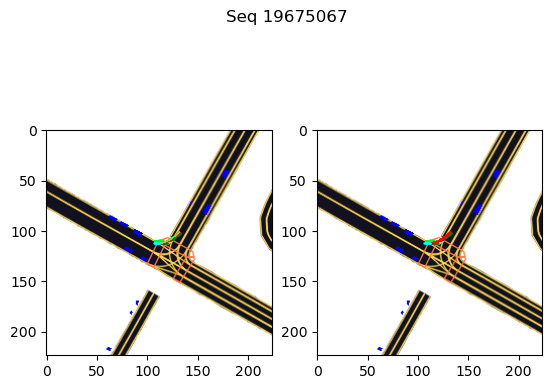

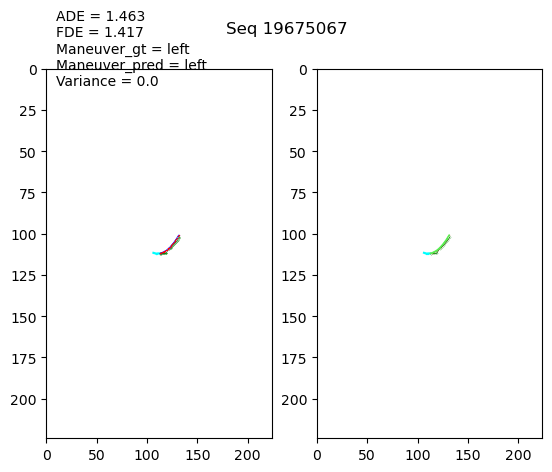

seq_id, ADE, FDE, maneuver_gt, maneuver_pred, outputs_var_mean =  3316941 0.4003427028656006 0.7859141826629639 3 3 0.0


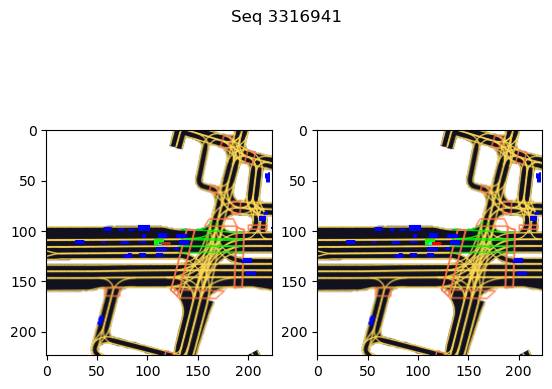

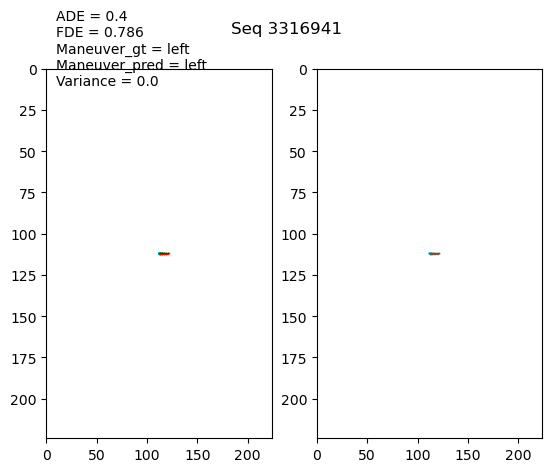

seq_id, ADE, FDE, maneuver_gt, maneuver_pred, outputs_var_mean =  21126357 0.9442925453186035 1.4096523523330688 3 3 0.0


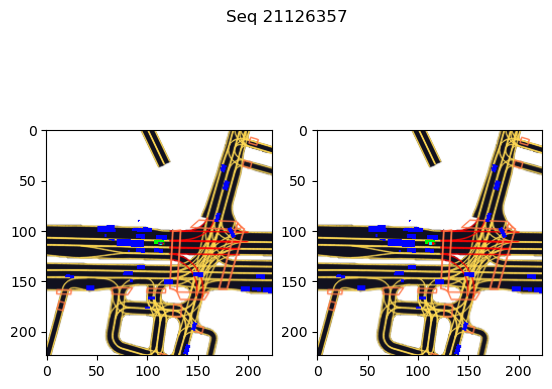

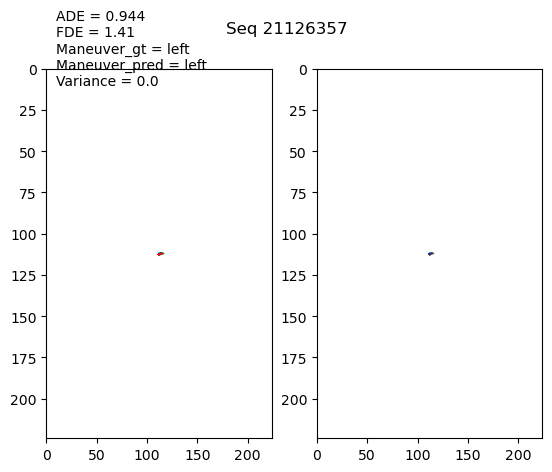

seq_id, ADE, FDE, maneuver_gt, maneuver_pred, outputs_var_mean =  22293277 1.009547472000122 2.9816231727600098 3 3 0.0


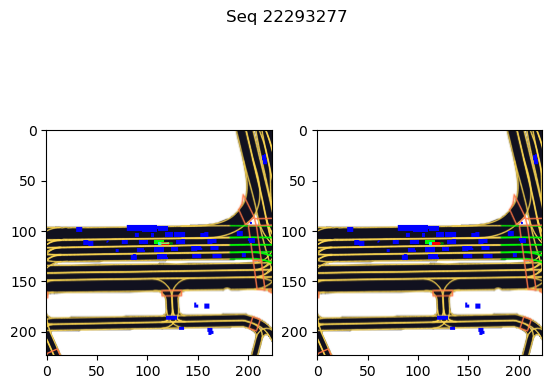

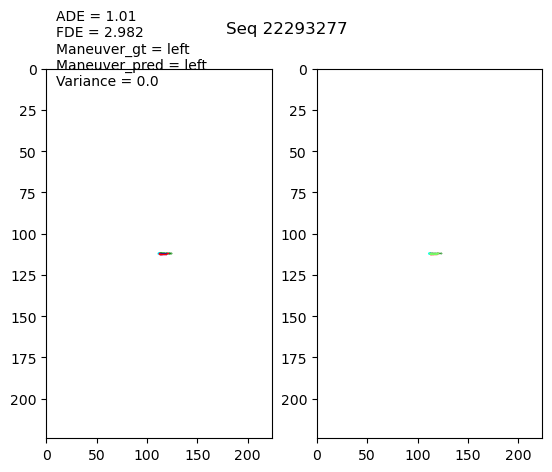

seq_id, ADE, FDE, maneuver_gt, maneuver_pred, outputs_var_mean =  17257679 3.1491761207580566 6.075216293334961 1 1 0.0


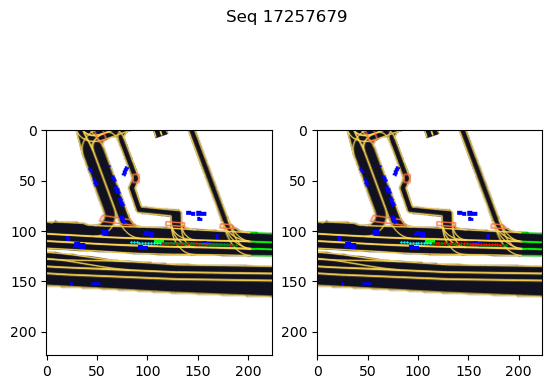

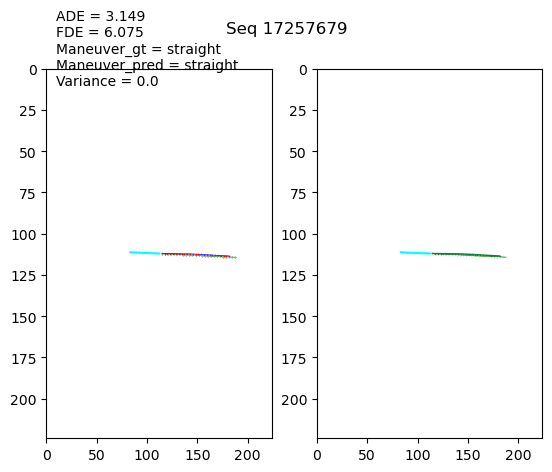

seq_id, ADE, FDE, maneuver_gt, maneuver_pred, outputs_var_mean =  1440372 1.8540818691253662 3.4461963176727295 1 1 0.0


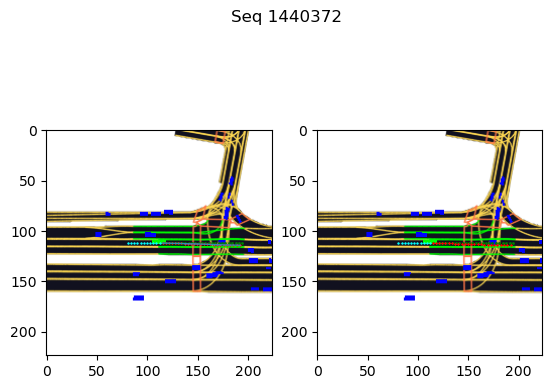

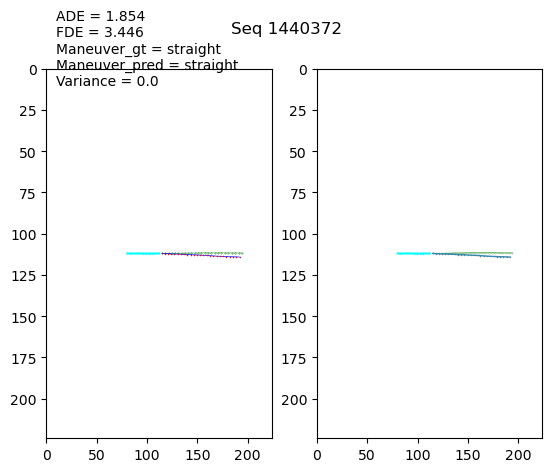

total_ADE 1.7556722627745733
total_FDE 3.7734751105308533
total_uncertainty 0.0
total_model_time = 0.18365324868096244
Straight_turn_accuracy 1.0
Right_turn_accuracy 0.8333333333333334
Left_turn_accuracy 0.8
Maneuver_classification 0.8888888888888888


In [9]:
counter_1 = 0
ade_list = []
fde_list = []
maneuver_gt = []
maneuver_outputs = []
variance_list = []

f=open(f"{config.plots}/ade-fde.txt","w+")
f.write("seq_id,ade,fde,maneuver_gt,maneuver_pred\n")

if config.DATASET == "SHIFT":
    test_loader_iter = test_loader_in
else:
    test_loader_iter = test_loader

noise = False
plot_figures = True
# validatioon function
ade_list, fde_list, maneuver_gt, maneuver_outputs, variance_list, f, test_time_list = evaluate(model, test_loader_iter, ade_list, fde_list, maneuver_gt, maneuver_outputs, variance_list, f, counter_1, noise, plot_figures)

# if config.DATASET == "SHIFT":
#     test_loader_iter = test_loader_out
# else:
#     test_loader_iter = test_loader_noise

# noise = True
# counter_1 = 0
# # validatioon function
# ade_list, fde_list, maneuver_gt, maneuver_outputs, variance_list, f = evaluate(model, test_loader_iter, ade_list, fde_list, maneuver_gt, maneuver_outputs, variance_list, f, counter_1, noise)

cm = confusion_matrix(maneuver_gt, maneuver_outputs)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# print(cm.diagonal())

f.write("total_ADE =" + str(sum(ade_list)/len(ade_list)) +"\n")
f.write("total_FDE =" + str(sum(fde_list)/len(fde_list)) +"\n")
f.write("total_uncertainty =" + str(sum(variance_list)/len(variance_list)) +"\n")
f.write("total_model_time =" + str(sum(test_time_list)/len(test_time_list)) +"\n")

if config.MANEUVER_PRESENT:
    f.write("Straight_turn_accuracy =" + str(cm.diagonal()[0]) +"\n")
    f.write("Right_turn_accuracy =" + str(cm.diagonal()[1]) +"\n")
    f.write("Left_turn_accuracy =" + str(cm.diagonal()[2]) +"\n")
    f.write("Maneuver_classification =" + str(accuracy_score(maneuver_gt, maneuver_outputs)) +"\n")
f.close()

print("total_ADE", sum(ade_list)/len(ade_list))
print("total_FDE", sum(fde_list)/len(fde_list))
print("total_uncertainty", sum(variance_list)/len(variance_list))
print("total_model_time =", sum(test_time_list)/len(test_time_list))

if config.MANEUVER_PRESENT:
    print("Straight_turn_accuracy", cm.diagonal()[0])
    print("Right_turn_accuracy", cm.diagonal()[1])
    print("Left_turn_accuracy", cm.diagonal()[2])
    print("Maneuver_classification", accuracy_score(maneuver_gt, maneuver_outputs))


In [11]:
#with IPEX
import intel_extension_for_pytorch as ipex
model = ipex.optimize(model)

counter_1 = 0
ade_list = []
fde_list = []
maneuver_gt = []
maneuver_outputs = []
variance_list = []

f=open(f"{config.plots}/ade-fde_ipex.txt","w+")
f.write("seq_id,ade,fde,maneuver_gt,maneuver_pred\n")

if config.DATASET == "SHIFT":
    test_loader_iter = test_loader_in
else:
    test_loader_iter = test_loader

noise = False
plot_figures = False
# validatioon function
ade_list, fde_list, maneuver_gt, maneuver_outputs, variance_list, f, test_time_list_ipex = evaluate(model, test_loader_iter, ade_list, fde_list, maneuver_gt, maneuver_outputs, variance_list, f, counter_1, noise, plot_figures)

# if config.DATASET == "SHIFT":
#     test_loader_iter = test_loader_out
# else:
#     test_loader_iter = test_loader_noise

# noise = True
# counter_1 = 0
# # validatioon function
# ade_list, fde_list, maneuver_gt, maneuver_outputs, variance_list, f = evaluate(model, test_loader_iter, ade_list, fde_list, maneuver_gt, maneuver_outputs, variance_list, f, counter_1, noise)

cm = confusion_matrix(maneuver_gt, maneuver_outputs)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# print(cm.diagonal())

f.write("total_ADE =" + str(sum(ade_list)/len(ade_list)) +"\n")
f.write("total_FDE =" + str(sum(fde_list)/len(fde_list)) +"\n")
f.write("total_uncertainty =" + str(sum(variance_list)/len(variance_list)) +"\n")
f.write("total_model_time =" + str(sum(test_time_list_ipex)/len(test_time_list_ipex)) +"\n")

if config.MANEUVER_PRESENT:
    f.write("Straight_turn_accuracy =" + str(cm.diagonal()[0]) +"\n")
    f.write("Right_turn_accuracy =" + str(cm.diagonal()[1]) +"\n")
    f.write("Left_turn_accuracy =" + str(cm.diagonal()[2]) +"\n")
    f.write("Maneuver_classification =" + str(accuracy_score(maneuver_gt, maneuver_outputs)) +"\n")
f.close()

print("total_ADE", sum(ade_list)/len(ade_list))
print("total_FDE", sum(fde_list)/len(fde_list))
print("total_uncertainty", sum(variance_list)/len(variance_list))
print("total_model_time =", sum(test_time_list_ipex)/len(test_time_list_ipex))

if config.MANEUVER_PRESENT:
    print("Straight_turn_accuracy", cm.diagonal()[0])
    print("Right_turn_accuracy", cm.diagonal()[1])
    print("Left_turn_accuracy", cm.diagonal()[2])
    print("Maneuver_classification", accuracy_score(maneuver_gt, maneuver_outputs))


seq_id, ADE, FDE, maneuver_gt, maneuver_pred, outputs_var_mean =  6157527 0.7262843251228333 1.8166513442993164 1 1 0.0
seq_id, ADE, FDE, maneuver_gt, maneuver_pred, outputs_var_mean =  6723974 4.310468673706055 7.408728122711182 3 1 0.0
seq_id, ADE, FDE, maneuver_gt, maneuver_pred, outputs_var_mean =  7732451 1.5894749164581299 4.06170654296875 1 1 0.0
seq_id, ADE, FDE, maneuver_gt, maneuver_pred, outputs_var_mean =  22374513 0.5564541816711426 1.7523902654647827 2 2 0.0
seq_id, ADE, FDE, maneuver_gt, maneuver_pred, outputs_var_mean =  276634 1.2765552997589111 3.33396315574646 1 1 0.0
seq_id, ADE, FDE, maneuver_gt, maneuver_pred, outputs_var_mean =  16086779 1.3750115633010864 4.270819664001465 2 2 0.0
seq_id, ADE, FDE, maneuver_gt, maneuver_pred, outputs_var_mean =  22108132 0.6932021379470825 0.9198428988456726 1 1 0.0
seq_id, ADE, FDE, maneuver_gt, maneuver_pred, outputs_var_mean =  8580403 1.2675986289978027 2.8245232105255127 2 2 0.0
seq_id, ADE, FDE, maneuver_gt, maneuver_pred,

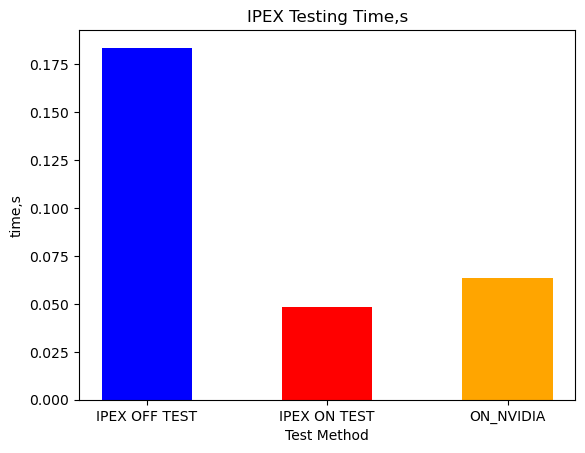

Performance Speedup Testing:  3.8120437143446284
[CODE_SAMPLE_COMPLETED_SUCCESFULLY]


In [5]:
#show performance boost
time_test = sum(test_time_list)/len(test_time_list) #0.18365324868096244
time_test_ipex = sum(test_time_list_ipex)/len(test_time_list_ipex) #0.048177109824286565
time_test_nvidia = 0.06347106562720405

pred_times = [time_test, time_test_ipex, time_test_nvidia]
tick_label = ['IPEX OFF TEST', 'IPEX ON TEST', 'ON_NVIDIA']

left = [1,2,3]
plt.bar(left, pred_times, tick_label = tick_label, width = 0.5, color = ['blue', 'red', 'orange'])
plt.xlabel('Test Method'); plt.ylabel('time,s'); plt.title('IPEX Testing Time,s')
plt.show()

# print("Performance Speedup Training: ",(time_train)/(time_train_ipex))
print("Performance Speedup Testing: ",(time_test)/(time_test_ipex))

print('[CODE_SAMPLE_COMPLETED_SUCCESFULLY]')
